In [8]:
import mujoco
import mediapy as media
import numpy as np

""

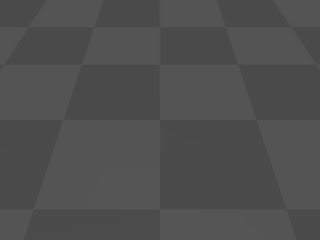

In [10]:
if 'renderer' in locals():
    del renderer
if 'model' in locals():
    del model
if 'data' in locals():
    del data


xml = """
<mujoco>
  <option timestep="0.005" iterations="50" integrator="RK4" tolerance="1e-10"/>

  <default>
	  <!--<joint type="hinge" pos="0 0 0" axis="0 0 1" limited="true" range="0 120" damping="0.1"/>-->
    <joint type="ball"/>
    <muscle ctrllimited="true" ctrlrange="-1000 1000"/>
    <geom size="0.003" mass="0.1" rgba=".5 .1 .1 1"/>
    <site size="0.005" rgba="0 .7 0 1"/>
    <tendon rgba="0 1 0 1" stiffness="1000" damping="15"/>
  </default>

  <asset>
    <texture name="texplane" type="2d" builtin="checker" rgb1=".25 .25 .25" rgb2=".28 .28 .28" width="512" height="512" markrgb=".8 .8 .8"/>
    <material name="matplane" reflectance="0.1" texture="texplane" texrepeat="1 1" texuniform="true"/>
  </asset>

  <worldbody>   
    <geom name="floor" rgba="1 1 1 1" pos="0 0 -0.35" size="0 0 1" type="plane" material="matplane"/>
    <light directional="true" diffuse=".8 .8 .8" specular=".2 .2 .2" pos="0 0 5" dir="0 0 -1"/>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

mujoco.mj_forward(model, data)
renderer.update_scene(data)

media.show_image(renderer.render())